# PSD for Each Ship Type for Multiple Locations

Can get PSD/Spectrogram data from MSEED in CSV.

Group By ship type


Compile all PSD data objects into list and plot them all on one plot?

Check following list for creation of SPDF with probabilities: https://github.com/Ocean-Data-Lab/Website-backend/blob/master/SpecGraph/SPDF.py


## NOTE 02/15
Find way to get PSD pickles from sharepoint

In [1]:
# data
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
import functions as fn
# plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json

### Testing 


#### Testing reading pickle files and creating PSD object
They're actually just JSONs for PSDs, not pickles

In [56]:
# f: frequency index bin
# psd: values
pklfilepath = 'data/Axial_Base/PSD_pickles/AB_20160826102337_20160826103337.json'
with open(pklfilepath, 'rb') as f:
    dict1 = json.load(f)
#dict1['psd']
testpsd = ooipy.Psd(dict1['f'], dict1['psd'])
#testpsd.freq

#### Testing dictionary usage

In [ ]:
# playing around with dictionaries to group PSD lists
empty_dict = {}
empty_dict.update({"zero": np.zeros(20)}) 
empty_dict.update({"ones": np.ones(20)}) 
empty_dict.update({"rand": (np.random.randint(10, size=20))}) 

empty_dict['1'] = 'The number 1'
empty_dict

#### Testing specs format from Website-Backend
https://github.com/Ocean-Data-Lab/Website-backend

In [38]:
import xarray as xr
# testing specs variable from SPDF.py from Website-Backend
fn = 'lf_specs.zarr'
specs = xr.open_dataset(fn)
specs = specs['axial_base']
specs.frequency
print(len(specs.frequency))
print(specs.frequency)
specs.values

257
<xarray.DataArray 'frequency' (frequency: 257)>
array([ 0.      ,  0.390625,  0.78125 , ..., 99.218742, 99.609367, 99.999992])
Coordinates:
  * frequency  (frequency) float64 0.0 0.3906 0.7812 1.172 ... 99.22 99.61 100.0


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [83.95746008, 92.68650471, 88.88153973, ..., 22.15120847,
        22.03953612, 18.02125879],
       ...,
       [82.833954  , 90.64178732, 86.3434385 , ..., 21.85440536,
        22.23472576, 17.60662589],
       [82.14352726, 90.44169891, 85.96472028, ..., 21.98427951,
        21.96509032, 16.89627881],
       [81.46665636, 90.16936625, 86.4834625 , ..., 21.73733632,
        21.97012369, 17.54791917]])

In [39]:
specs.values.transpose()

array([[        nan,         nan, 83.95746008, ..., 82.833954  ,
        82.14352726, 81.46665636],
       [        nan,         nan, 92.68650471, ..., 90.64178732,
        90.44169891, 90.16936625],
       [        nan,         nan, 88.88153973, ..., 86.3434385 ,
        85.96472028, 86.4834625 ],
       ...,
       [        nan,         nan, 22.15120847, ..., 21.85440536,
        21.98427951, 21.73733632],
       [        nan,         nan, 22.03953612, ..., 22.23472576,
        21.96509032, 21.97012369],
       [        nan,         nan, 18.02125879, ..., 17.60662589,
        16.89627881, 17.54791917]])

In [17]:
(specs.values.transpose()[:257]).shape

(257, 197836)

In [5]:
int(len(specs.frequency) * 100/(200/2)) + 1

258

### Collecting data for each ship type in Axial Base

In [9]:
AB_df = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv',sep = ',')
grouped_AB_df = AB_df.dropna(subset=['psd_pickle']).groupby('ud_group')
# cumsum for looking at amount of rows iterated thru, unnecessary tbh
cumsum = 0
# Pull PSD data for each groups from the MSEED
# https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
# .dropna() followed by .groupby() cleans and groups
AB_PSDs = {}
for group_name, df_group in grouped_AB_df:
    PSD_obj_list = []

    # for-loop to compile list of PSD data objects pulled from column
    # some stackoverflow post said to be careful w/ iterating thru rows due to memory
    for row_index, row in df_group.iterrows():
        #print(row_index)
        inst_id = AB_df['instance_id'].iloc[row_index]
        #print((row_index))
        cumsum+=1
        # get pickle files (DL locally? Call some API?)
        # local storage method
        AB_data_path = 'data/Axial_Base/'
        pklfilepath = AB_data_path + 'PSD_pickles/' + inst_id + '.json'
        with open(pklfilepath, 'rb') as f:
            dict1 = json.load(f)

        # create PSD object
        # fill out PSD object fields
        psd = ooipy.Psd(dict1['f'], dict1['psd'])
        # add PSD object to PSD_obj_list
        PSD_obj_list.append(psd)

    AB_PSDs.update({group_name: PSD_obj_list})

### above, but modified

In [74]:
AB_df = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv',sep = ',')
grouped_AB_df = AB_df.dropna(subset=['psd_pickle']).groupby('ud_group')
# cumsum for looking at amount of rows iterated thru, unnecessary tbh
cumsum = 0
# Pull PSD data for each groups from the MSEED
# https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
# .dropna() followed by .groupby() cleans and groups
AB_PSDs = {}
for group_name, df_group in grouped_AB_df:
    
    PSD_obj_list = []
    PSD_freq = []
    PSD_val = []
    dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

    # for-loop to compile list of PSD data objects pulled from column
    # some stackoverflow post said to be careful w/ iterating thru rows due to memory
    for row_index, row in df_group.iterrows():
        #print(row_index)
        inst_id = AB_df['instance_id'].iloc[row_index]
        #print((row_index))
        cumsum+=1
        # get pickle files (DL locally? Call some API?)
        # local storage method
        AB_data_path = 'data/Axial_Base/'
        pklfilepath = AB_data_path + 'PSD_pickles/' + inst_id + '.json'
        with open(pklfilepath, 'rb') as f:
            dict1 = json.load(f)

        # create PSD object
        # fill out PSD object fields
        psd = ooipy.Psd(dict1['f'], dict1['psd'])
        # add PSD object to PSD_obj_list
        #PSD_obj_list.append(psd)
        dictPSD['objects'].append(psd)
        dictPSD['frequencies'].append(psd.freq)
        dictPSD['values'].append(psd.values)

    AB_PSDs.update({group_name: dictPSD})

In [41]:
len(AB_PSDs['Research']['frequencies'][0])
np.asarray(AB_PSDs['Research']['values'])

array([[68.03441984, 77.38297408, 77.02040186, ..., 22.38715617,
        22.34637194, 17.44972395],
       [67.51862182, 77.09786308, 76.78178411, ..., 22.04540367,
        21.638058  , 17.13541273],
       [67.58484345, 77.11771468, 76.83957457, ..., 22.19979554,
        22.21826067, 16.52423957],
       ...,
       [72.70311402, 81.81061314, 80.61040187, ..., 22.41800288,
        22.21743302, 16.74872466],
       [73.20110559, 81.57065263, 80.16185652, ..., 21.95486134,
        22.21976462, 18.16507403],
       [72.63184816, 81.27864246, 80.17390787, ..., 22.18142359,
        21.86490932, 17.4292668 ]])

In [40]:

np.asarray(AB_PSDs['Research']['values']).T

array([[68.03441984, 67.51862182, 67.58484345, ..., 72.70311402,
        73.20110559, 72.63184816],
       [77.38297408, 77.09786308, 77.11771468, ..., 81.81061314,
        81.57065263, 81.27864246],
       [77.02040186, 76.78178411, 76.83957457, ..., 80.61040187,
        80.16185652, 80.17390787],
       ...,
       [22.38715617, 22.04540367, 22.19979554, ..., 22.41800288,
        21.95486134, 22.18142359],
       [22.34637194, 21.638058  , 22.21826067, ..., 22.21743302,
        22.21976462, 21.86490932],
       [17.44972395, 17.13541273, 16.52423957, ..., 16.74872466,
        18.16507403, 17.4292668 ]])

In [61]:

# function pulled from the repo     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this ain't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

In [88]:
def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    #my_stringIObytes = io.BytesIO()
    filepath = 'data/Axial_Base/'
    plt.savefig(filepath+shipType+'.jpg', format='jpg')
    #my_stringIObytes.seek(0)
    #img_base64 = base64.b64encode(my_stringIObytes.read())
    #return jsonify({'image': str(img_base64)})

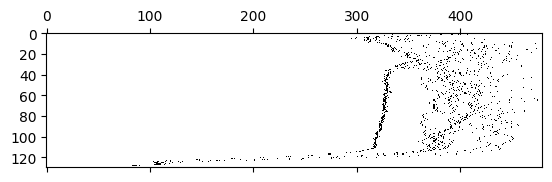

In [77]:
plt.spy(get_spdf(AB_PSDs['Tanker'])['pdf'])

Cargo
Fishing type
Passenger
Recreational
Research
Tanker


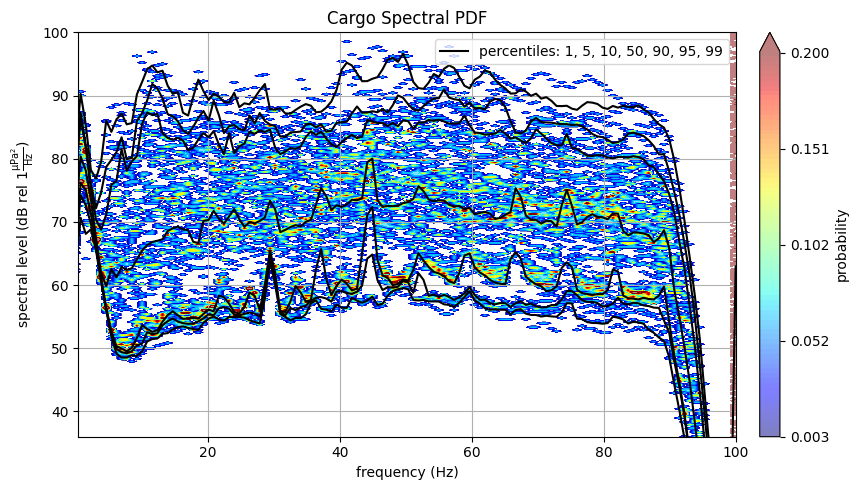

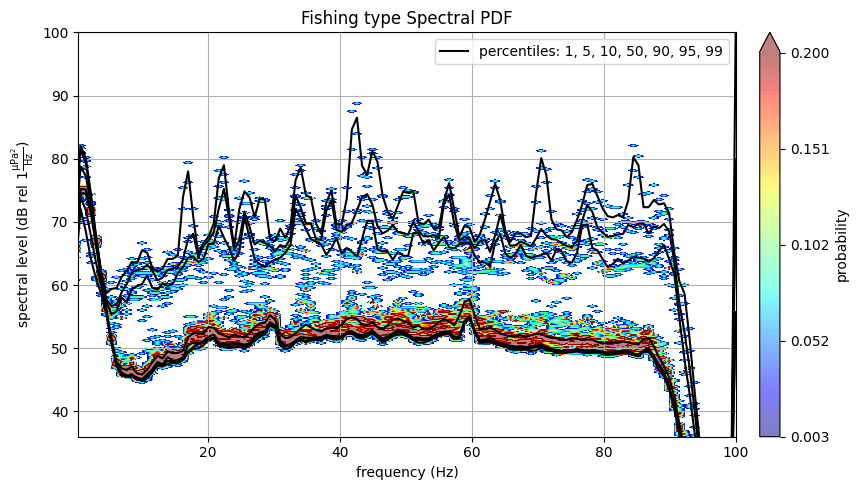

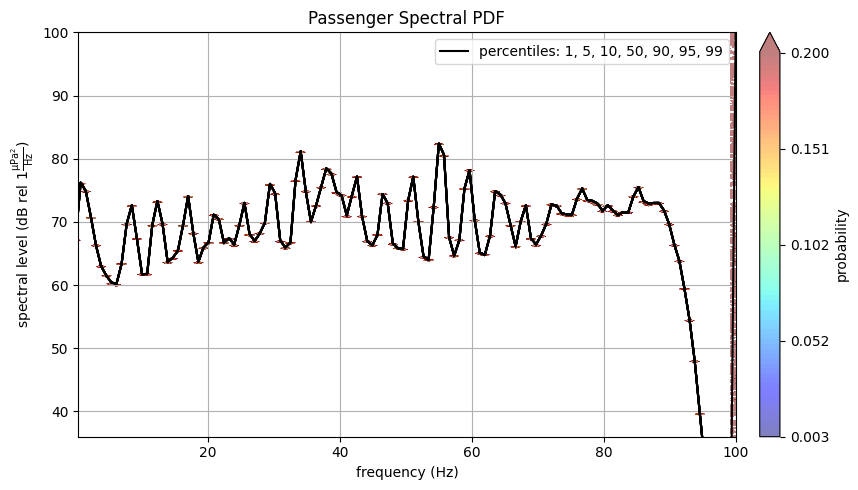

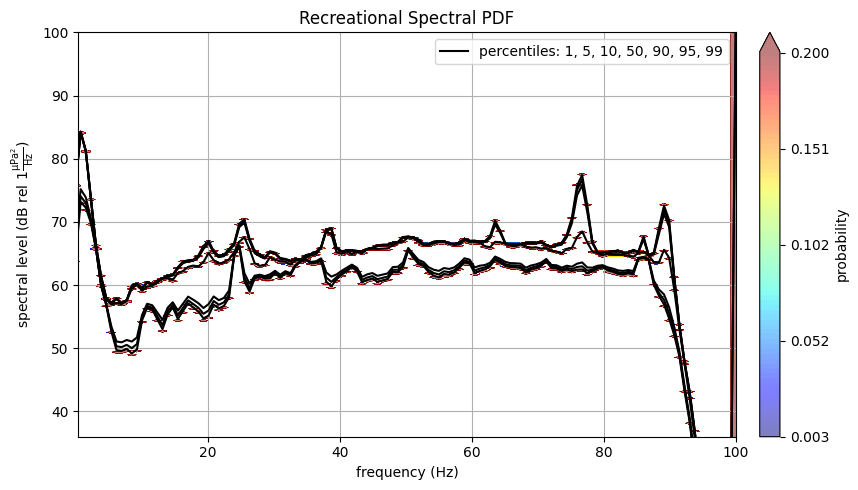

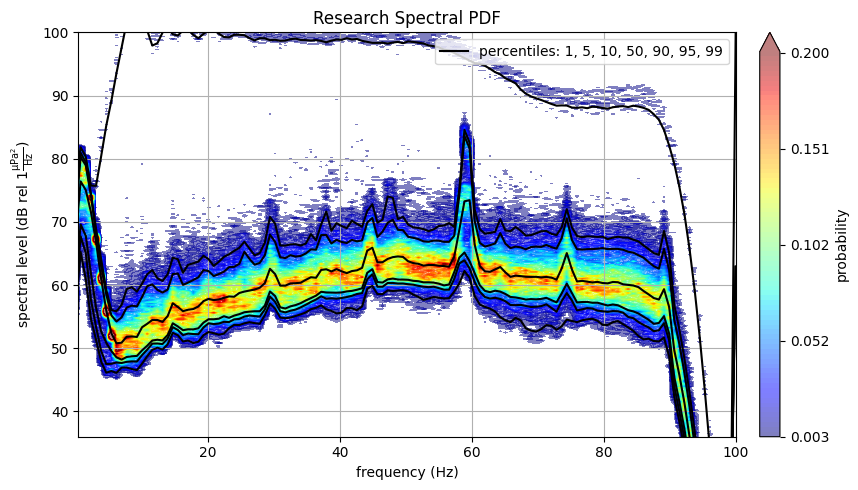

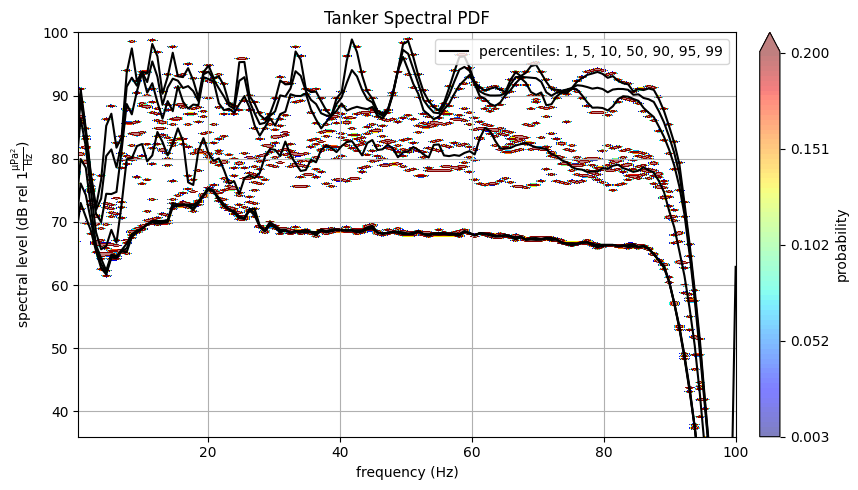

In [89]:
for key in AB_PSDs:
    print((key))
    spdf = get_spdf(AB_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key)
    